# [Fraud in Wine](https://en.wikipedia.org/wiki/Wine_fraud)

Wine fraud encompasses the business aspects of the wine industry. The primary form of fraud involves the adulteration of wines, typically by adding lower-cost substances such as juices, occasionally accompanied by potentially harmful chemicals and sweeteners, which aim to compensate for color or flavor deficiencies.

Additionally, counterfeiting and the act of relabeling inferior and cheaper wines to pass them off as higher-priced brands are frequent occurrences in wine fraud.

## Project Goals

The primary objective is to utilize the wine dataset presented below in order to construct a machine learning model that endeavors to forecast whether a wine is categorized as "Legit" or "Fraudulent" using a range of chemical characteristics.

Data Source: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*


**Importing the libraries and loading the dataset.**

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv("wine_fraud.csv")

In [71]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


**Let's take a look at the variables in the target column**

In [72]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

In [73]:
df['quality'].value_counts()

Legit    6251
Fraud     246
Name: quality, dtype: int64

**Now let's visualize the distribution in the `quality` column**

Text(0.5, 1.0, 'Wine quality count')

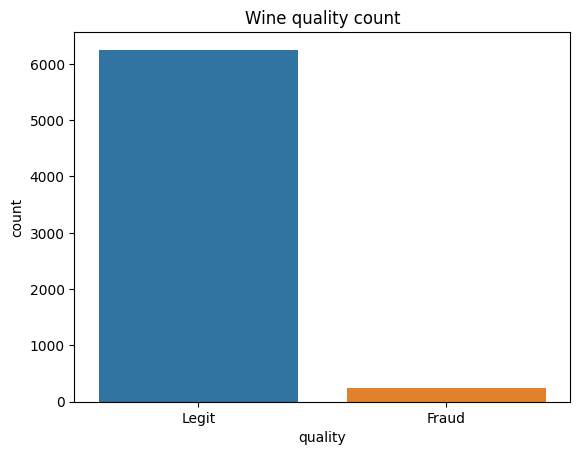

In [74]:
sns.countplot(data=df,x='quality')
plt.title('Wine quality count')

**Let's find out if there is a difference between red and white wine when it comes to fraud.**

Text(0.5, 1.0, 'Wine quality count per wine type')

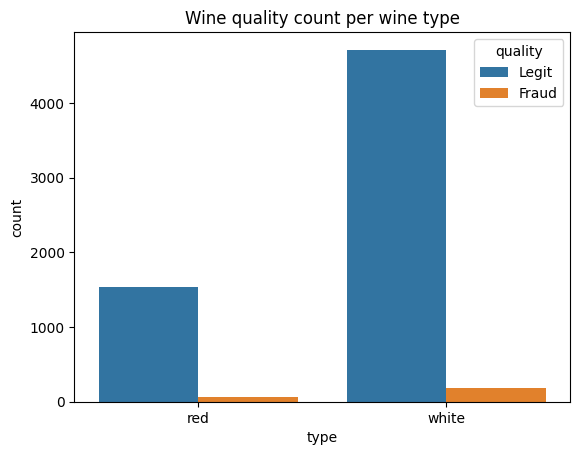

In [75]:
sns.countplot(data=df,x='type',hue='quality')
plt.title('Wine quality count per wine type')

**What is the percentage of fraud among the different types of wines?**

In [76]:
red_fraud = (df['type']=='red') & (df['quality']=='Fraud')
red_fraud.sum()*100/len(df[df['type']=='red'])

3.9399624765478425

In [77]:
white_fraud = (df['type']=='white') & (df['quality']=='Fraud')
white_fraud.sum()*100/len(df[df['type']=='white'])

3.736218864842793

**Which features are directly or inverse correlated with wine fraud?**

In [78]:
# Mapping the quality column with 0 and 1 
df['Fraud']= df['quality'].map({'Legit':0,'Fraud':1})

In [79]:
df.corr()['Fraud'].sort_values()

free sulfur dioxide    -0.085204
citric acid            -0.061789
alcohol                -0.051141
residual sugar         -0.048756
total sulfur dioxide   -0.035252
sulphates              -0.034046
density                 0.016351
pH                      0.020107
fixed acidity           0.021794
chlorides               0.034499
volatile acidity        0.151228
Fraud                   1.000000
Name: Fraud, dtype: float64

**Let's visualize it by creating a barplot**

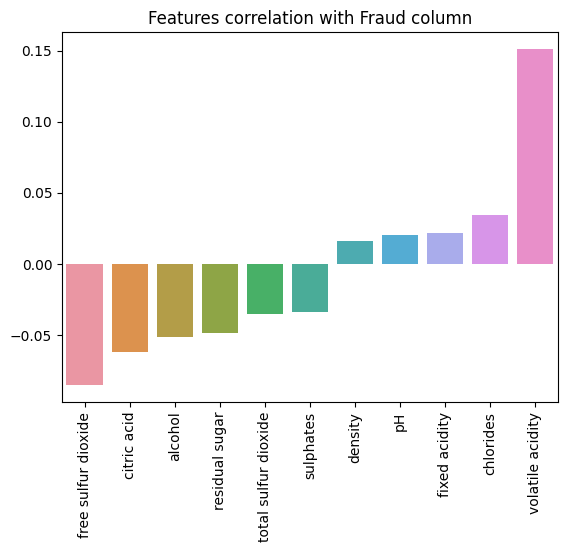

In [80]:
dados = df.corr()['Fraud'].drop('Fraud',axis=0).sort_values()
sns.barplot(x=dados.index,y=dados.values)
plt.xticks(rotation=90)
plt.title('Features correlation with Fraud column')
plt.show()

**A clustermap is going to show us relationships between variables, let's take a look**

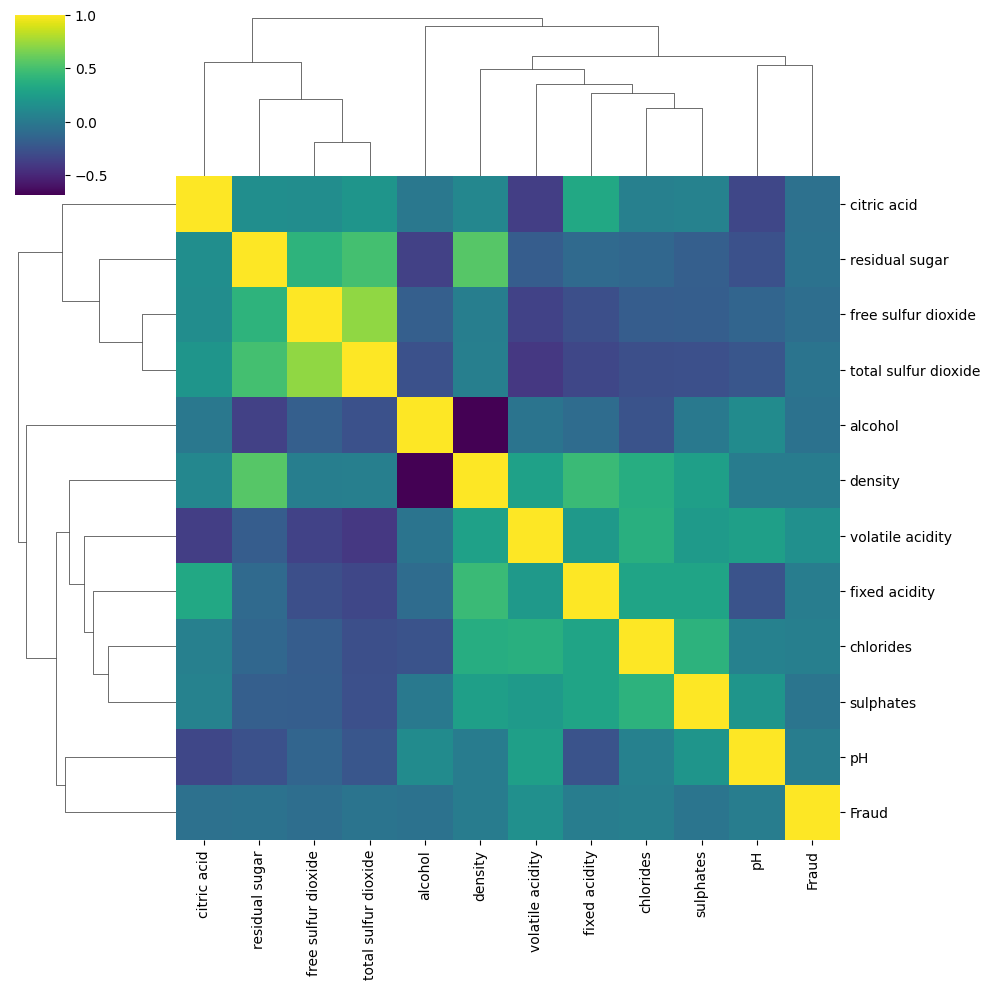

In [81]:
sns.clustermap(df.corr(),cmap='viridis')

## Machine Learning Model

**Converting the categorical column "type" from a string or "red" or "white" to dummy variables:**

In [82]:
# Creating dummy variables for the type column
df['type'] = pd.get_dummies(df['type'],drop_first=True)

In [83]:
# Get rid of the Fraud column
df = df.drop('Fraud',axis=1)

**Separating the data into X features and y target label ("quality" column)**

In [84]:
X = df.drop('quality',axis=1)
y = df['quality']

**Performing a Train/Test split on the data, with a 10% test size.**

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.1,random_state=101)

**Scaling the X train and X test data.**

In [87]:
from sklearn.preprocessing import StandardScaler

In [88]:
scaler = StandardScaler()

In [89]:
X_train_scaled = scaler.fit_transform(X_train)

In [90]:
X_test_scaled = scaler.transform(X_test)

**As we saw earlier, the classes are unbalanced, so we need to adjust weights inversely proportional to class frequencies in the input data with a argument in the SVC instance. Reading the [SVC scikitlearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), we found the parameter `class_weight` with the argument `balanced` do the trick**

In [91]:
from sklearn.svm import SVC

In [92]:
svc = SVC(class_weight='balanced')

**TASK: Use a GridSearchCV to run a grid search for the best C and gamma parameters.**

In [93]:
from sklearn.model_selection import GridSearchCV

In [94]:
param_grid = {'C':[0.001,0.01,0.1,0.5,1],'gamma':['scale','auto']}
grid = GridSearchCV(svc,param_grid)

In [95]:
grid.fit(X_train_scaled,y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto']})

In [96]:
grid.best_params_

{'C': 1, 'gamma': 'auto'}

**TASK: Display the confusion matrix and classification report for your model.**

In [97]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

In [98]:
grid_pred = grid.predict(X_test_scaled)

In [99]:
confusion_matrix(y_test,grid_pred)

array([[ 17,  10],
       [ 92, 531]])

/home/lcl1m4dev/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


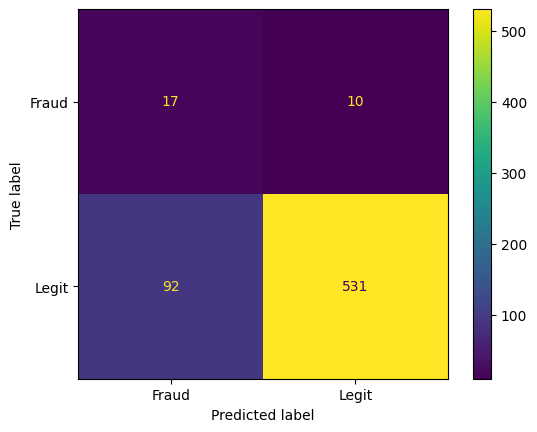

In [100]:
plot_confusion_matrix(grid,X_test_scaled, y_test)

In [101]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

       Fraud       0.16      0.63      0.25        27
       Legit       0.98      0.85      0.91       623

    accuracy                           0.84       650
   macro avg       0.57      0.74      0.58       650
weighted avg       0.95      0.84      0.88       650



**Final thoughts**

As we can see, the metrics of the model for classifying wines as fraudulent were not very good, despite the initial purpose of the classification model being to identify originally fraudulent wines that were being classified as legitimate (only 10 were misclassified!). Additionally, relying solely on chemical analysis is not sufficient to classify wines; other characteristics such as origin, labeling and manufacturing can influence the final outcome. Therefore, the initial analysis using the classifier is a good start, but the addition of new features and more data can significantly improve the results.